In [ ]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib 
import importlib 
import shap 
import matplotlib.pyplot as plt

c:\Users\asus\OneDrive\Desktop\projects\house_price_prediction\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
notebook_path = os.path.abspath('') 

project_root = os.path.abspath(os.path.join(notebook_path, '..'))

if project_root not in sys.path:
    sys.path.append(project_root)
    print(f"Added {project_root} to sys.path for module import.")
else:
    print(f"{project_root} already in sys.path.")

Added c:\Users\asus\OneDrive\Desktop\projects\house_price_prediction to sys.path for module import.


In [ ]:
try:
    # Import modules as full names first
    import src.data_loader as data_loader_module
    import src.preprocessor as preprocessor_module
    import src.model_trainer as model_trainer_module
    import src.utils as utils_module

    # Force reload them to pick up any changes
    importlib.reload(data_loader_module)
    importlib.reload(preprocessor_module)
    importlib.reload(model_trainer_module)
    importlib.reload(utils_module)

    # Now import specific functions from the reloaded modules
    from src.data_loader import load_and_initial_clean
    from src.preprocessor import build_preprocessor
    from src.model_trainer import train_and_evaluate_models, load_model, save_model
    from src.utils import plot_feature_importance

    print("Successfully reloaded src modules and imported functions.")
except ImportError as e:
    print(f"CRITICAL ERROR: Failed to import or reload src modules: {e}")
    print("Please ensure your 'src' folder exists, contains __init__.py, and verify your Jupyter working directory setup.")
    
    sys.exit("Exiting notebook due to module import failure.")

# --- 0. Load and Preprocess Data ---
DATA_PATH = '../data/AmesHousing.csv' 

df = load_and_initial_clean(DATA_PATH)
if df is None:
    print("Failed to load data. Exiting notebook.")
    sys.exit("Exiting due to data loading failure.") 


Successfully reloaded src modules and imported functions.
DataFrame columns standardized using a robust method in data_loader.py.
Dropped 'order' column.
Dropped 'pid' column.
Data loaded and initially cleaned. Shape: (2930, 80)


In [4]:
y = df['saleprice']
X = df.drop('saleprice', axis=1)
y_log = np.log1p(y)


In [ ]:
preprocessor_pipeline_builder, X_processed_for_split = build_preprocessor(X)

# Split data for consistent X_test 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_processed_for_split, y_log, test_size=0.2, random_state=42)
print(f"\nData split into training and testing sets for explainability.")

model_save_path = '../models/best_house_price_model_xgboost.pkl'



Starting feature engineering and preprocessor building...

DEBUG (preprocessor.py): Columns in X_processed after initial copy: ['ms_subclass', 'ms_zoning', 'lot_frontage', 'lot_area', 'street', 'alley', 'lot_shape', 'land_contour', 'utilities', 'lot_config', 'land_slope', 'neighborhood', 'condition_1', 'condition_2', 'bldg_type', 'house_style', 'overall_qual', 'overall_cond', 'year_built', 'year_remod_add', 'roof_style', 'roof_matl', 'exterior_1st', 'exterior_2nd', 'mas_vnr_type', 'mas_vnr_area', 'exter_qual', 'exter_cond', 'foundation', 'bsmt_qual', 'bsmt_cond', 'bsmt_exposure', 'bsmtfin_type_1', 'bsmtfin_sf_1', 'bsmtfin_type_2', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'total_bsmt_sf', 'heating', 'heating_qc', 'central_air', 'electrical', '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath', 'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd', 'functional', 'fireplaces', 'fireplace_qu', 'garage_type', 'garage_y

In [ ]:
best_xgboost_model = None 
try:
    best_xgboost_model = load_model(model_save_path)
    print(f"Successfully loaded best XGBoost model from {model_save_path}.")
except FileNotFoundError:
    print(f"Warning: Model not found at {model_save_path}. Re-training models as a fallback.")
    
    models_dict = { 
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(random_state=42),
        'Lasso': Lasso(random_state=42),
        'RandomForest': RandomForestRegressor(random_state=42, n_jobs=-1),
        'XGBoost': XGBRegressor(random_state=42, n_jobs=-1, eval_metric='rmse')
    }
    param_grids_dict = {
        'LinearRegression': {},
        'Ridge': {'regressor__alpha': [0.1, 1.0, 10.0]},
        'Lasso': {'regressor__alpha': [0.0001, 0.001, 0.01]},
        'RandomForest': {
            'regressor__n_estimators': [100, 200],
            'regressor__max_depth': [10, 20, None]
        },
        'XGBoost': {
            'regressor__n_estimators': [100, 200],
            'regressor__learning_rate': [0.05, 0.1],
            'regressor__max_depth': [3, 5]
        }
    }
    # Pass the preprocessor_pipeline_builder
    results_from_training, best_trained_models_from_fallback = train_and_evaluate_models(
        X_train, y_train, X_test, y_test, preprocessor_pipeline_builder
    )
    best_xgboost_model = best_trained_models_from_fallback['XGBoost']
    print("XGBoost model acquired via re-training.")

if best_xgboost_model is None:
    print("Error: Could not acquire XGBoost model for explainability. Exiting.")
    exit()


xgboost_regressor = best_xgboost_model.named_steps['regressor']
preprocessor = best_xgboost_model.named_steps['preprocessor'] 



Model loaded from: ../models/best_house_price_model_xgboost.pkl
Successfully loaded best XGBoost model from ../models/best_house_price_model_xgboost.pkl.


In [ ]:
import os


figures_dir = '../reports/figures'

os.makedirs(figures_dir, exist_ok=True)
print(f"Ensured figures directory exists: {figures_dir}")



Ensured figures directory exists: ../reports/figures


In [ ]:
# Prepare data for SHAP: X_test needs to be transformed by the fitted preprocessor
X_test_processed = preprocessor.transform(X_test)

try:
    feature_names_out = preprocessor.get_feature_names_out()
    print("Feature names obtained from preprocessor.get_feature_names_out().")
except AttributeError:
    
    print("Warning: get_feature_names_out() not available. Attempting manual feature name reconstruction.")
    all_feature_names = []
    for name, transformer, original_cols in preprocessor.transformers_:
        if name == 'num':
            all_feature_names.extend(original_cols)
        elif name == 'ord':
            all_feature_names.extend(original_cols) 
        elif name == 'nom':
            
            ohe_step = transformer.named_steps['onehot']
            ohe_names = ohe_step.get_feature_names_out(original_cols)
            all_feature_names.extend(ohe_names)
        elif name == 'remainder' and transformer != 'drop':
            
            pass 
    feature_names_out = all_feature_names

Feature names obtained from preprocessor.get_feature_names_out().


In [9]:
X_test_processed_df = pd.DataFrame(X_test_processed, columns=feature_names_out)
print(f"X_test_processed_df shape for SHAP: {X_test_processed_df.shape}")
print(f"X_test_processed_df columns (first 5): {X_test_processed_df.columns.tolist()[:5]}")



X_test_processed_df shape for SHAP: (586, 227)
X_test_processed_df columns (first 5): ['num__ms_subclass', 'num__lot_frontage', 'num__overall_qual', 'num__overall_cond', 'num__year_remod_add']


In [10]:
# --- SHAP Explainer ---
print("\nGenerating SHAP explanations...")
explainer = shap.TreeExplainer(xgboost_regressor)

# Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test_processed_df)



Generating SHAP explanations...


Displaying SHAP summary plots...


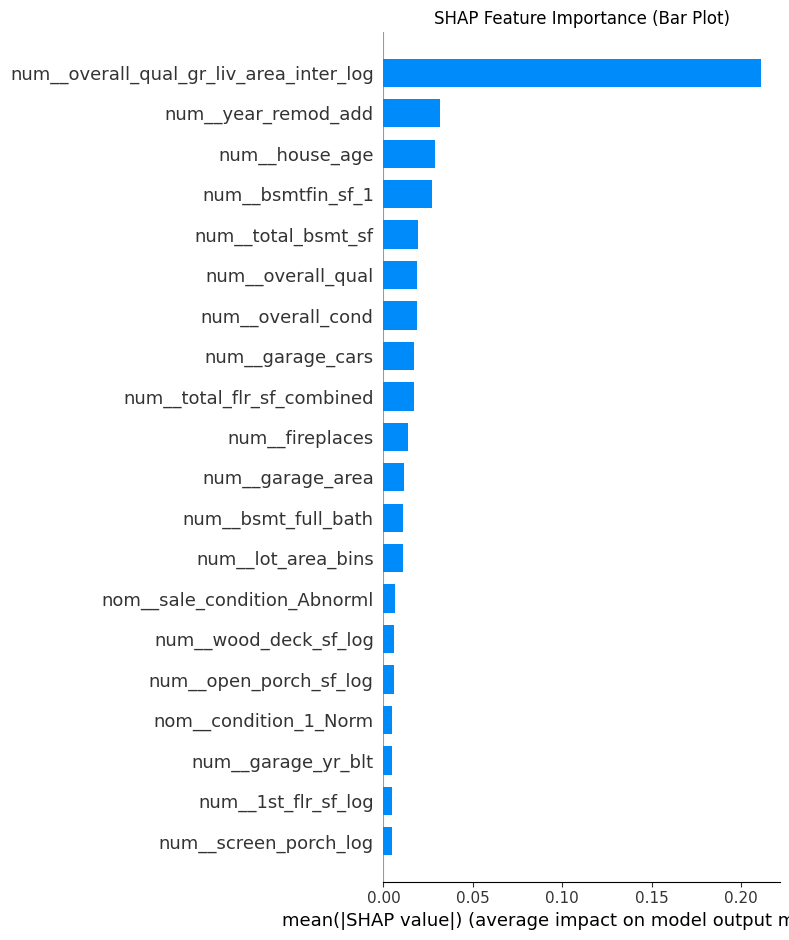

In [ ]:
# Summary plot
print("Displaying SHAP summary plots...")
shap.initjs()

# Bar plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_processed_df, plot_type="bar", show=False)
plt.title('SHAP Feature Importance (Bar Plot)')
plt.tight_layout()
plt.savefig('../reports/figures/shap_bar_importance.png')
plt.show()

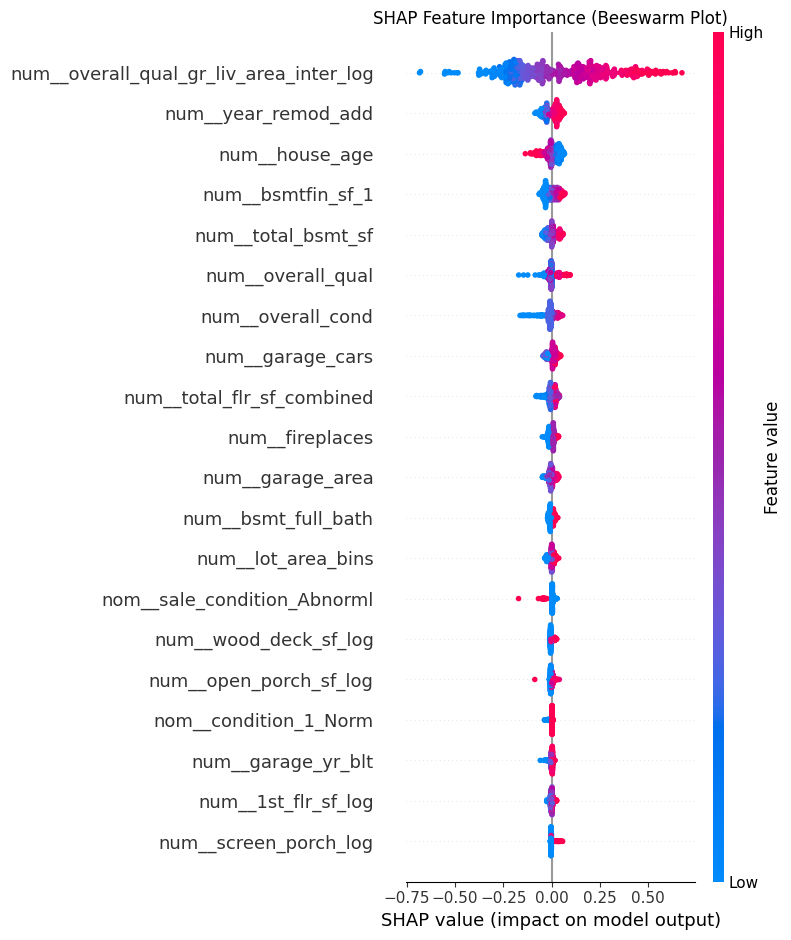

In [12]:
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_test_processed_df, show=False) # Beeswarm plot
plt.title('SHAP Feature Importance (Beeswarm Plot)')
plt.tight_layout()
plt.savefig('../reports/figures/shap_beeswarm_importance.png')
plt.show()



Displaying SHAP force plot for sample 0 from test set...


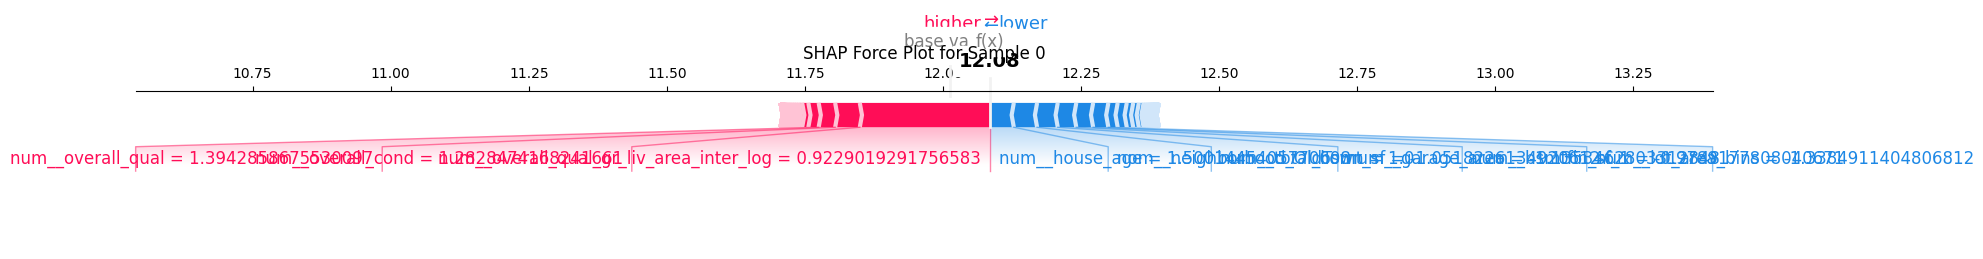

In [13]:
sample_idx = 0
print(f"\nDisplaying SHAP force plot for sample {sample_idx} from test set...")
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[sample_idx,:], X_test_processed_df.iloc[sample_idx,:], show=False, matplotlib=True) # matplotlib=True for static plot
plt.title(f'SHAP Force Plot for Sample {sample_idx}')
plt.tight_layout()
plt.savefig(f'../reports/figures/shap_force_plot_sample_{sample_idx}.png')
plt.show()



Plotting Feature Importance for XGBoost Model...


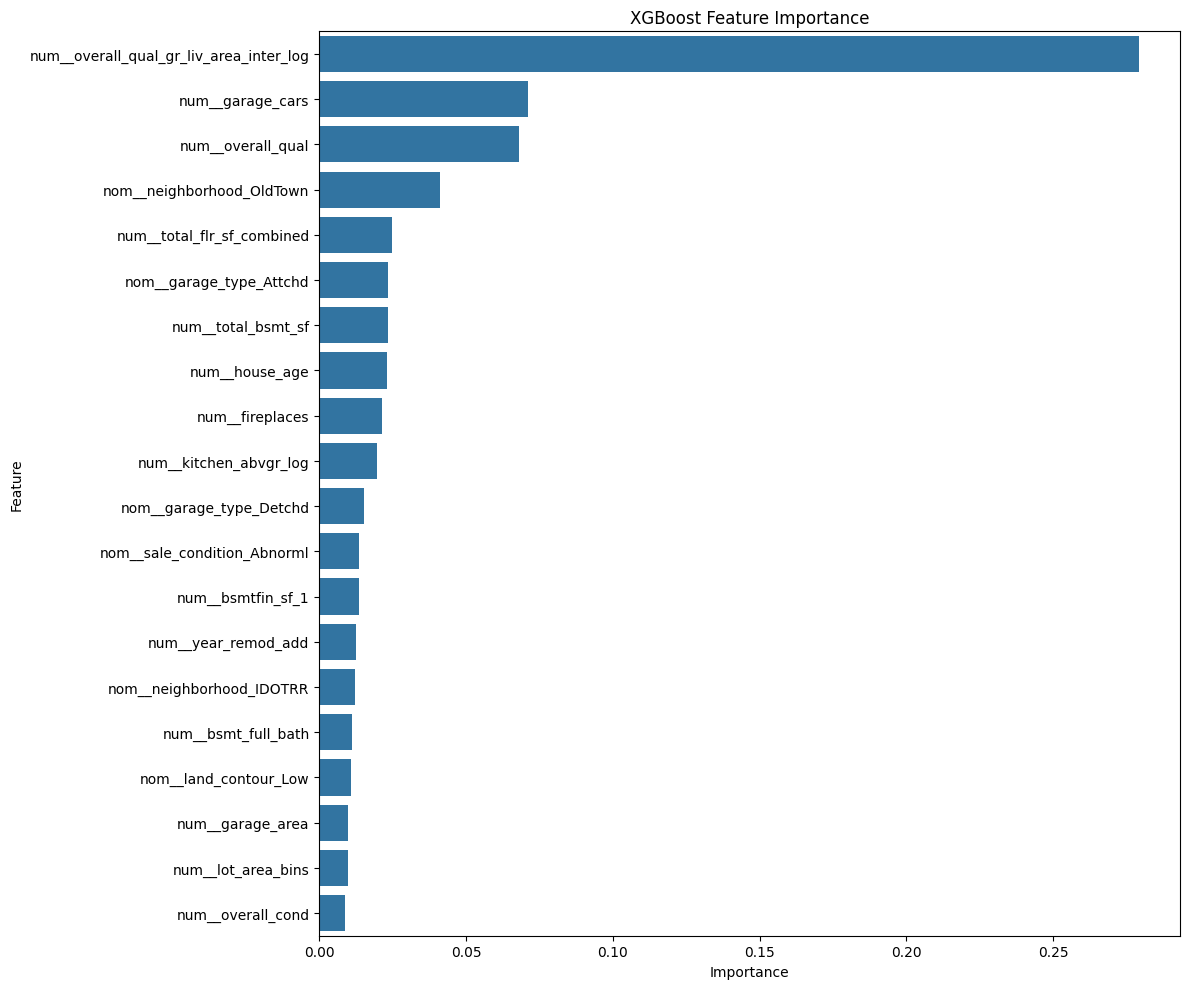

In [ ]:

from src.utils import plot_feature_importance

print("\nPlotting Feature Importance for XGBoost Model...")
plot_feature_importance(best_xgboost_model, n_top_features=20, title='XGBoost Feature Importance')

